In [1]:
import matplotlib as mpl
import numpy as np
import glob
import gzip
import os
import shutil
import tempfile
import netCDF4 as nc4
import pylab as plt
from matplotlib.legend import Legend

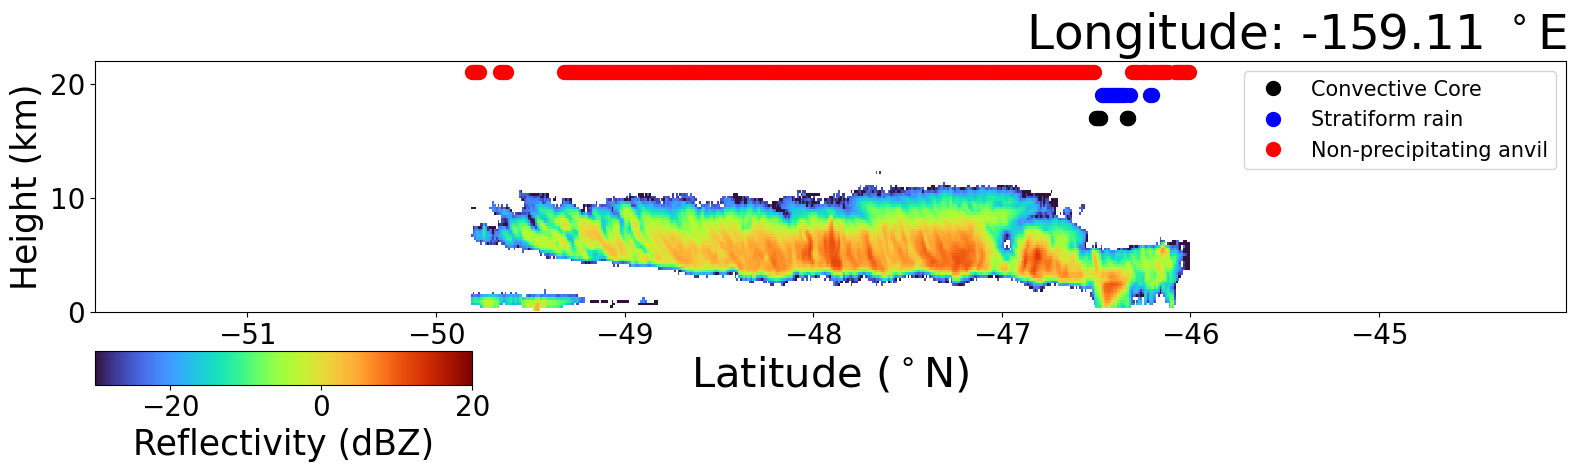

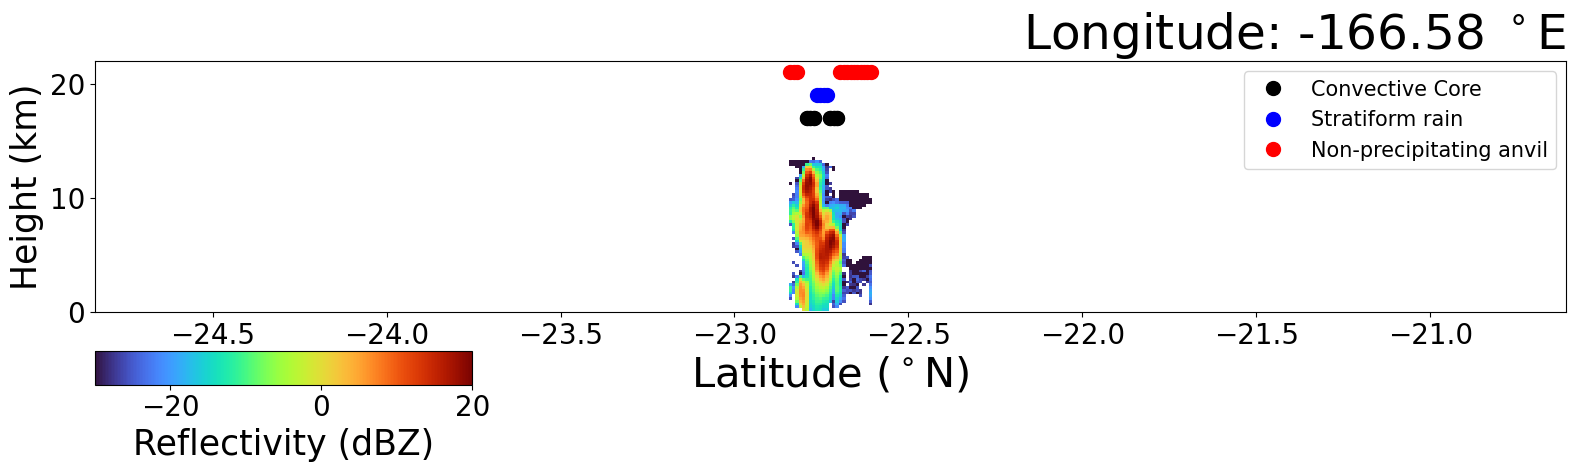

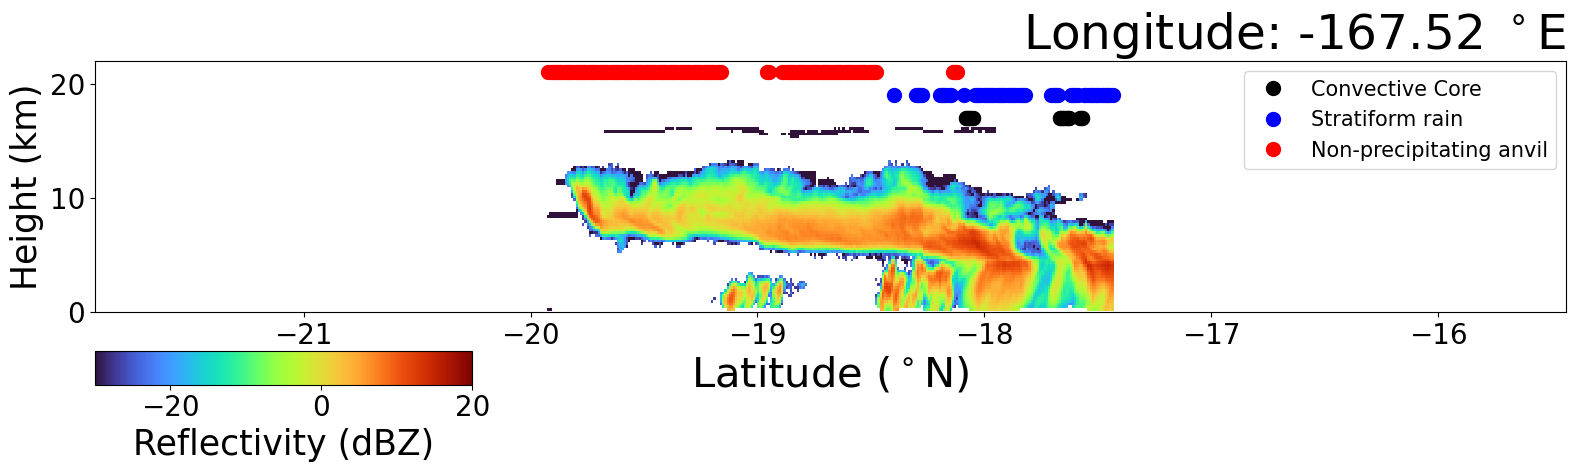

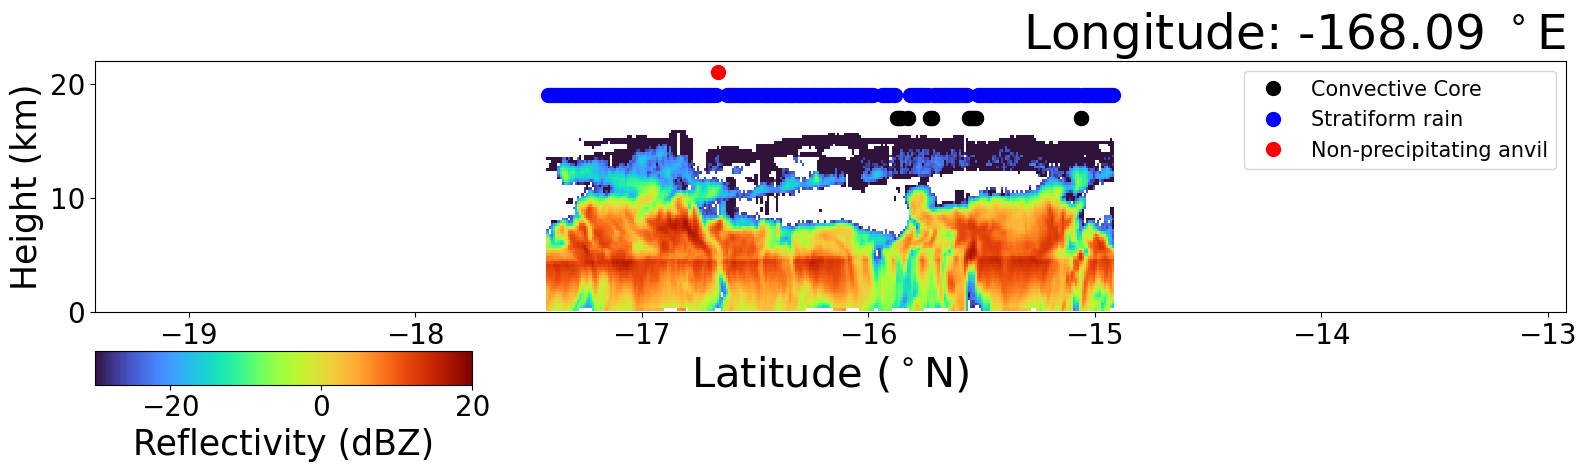

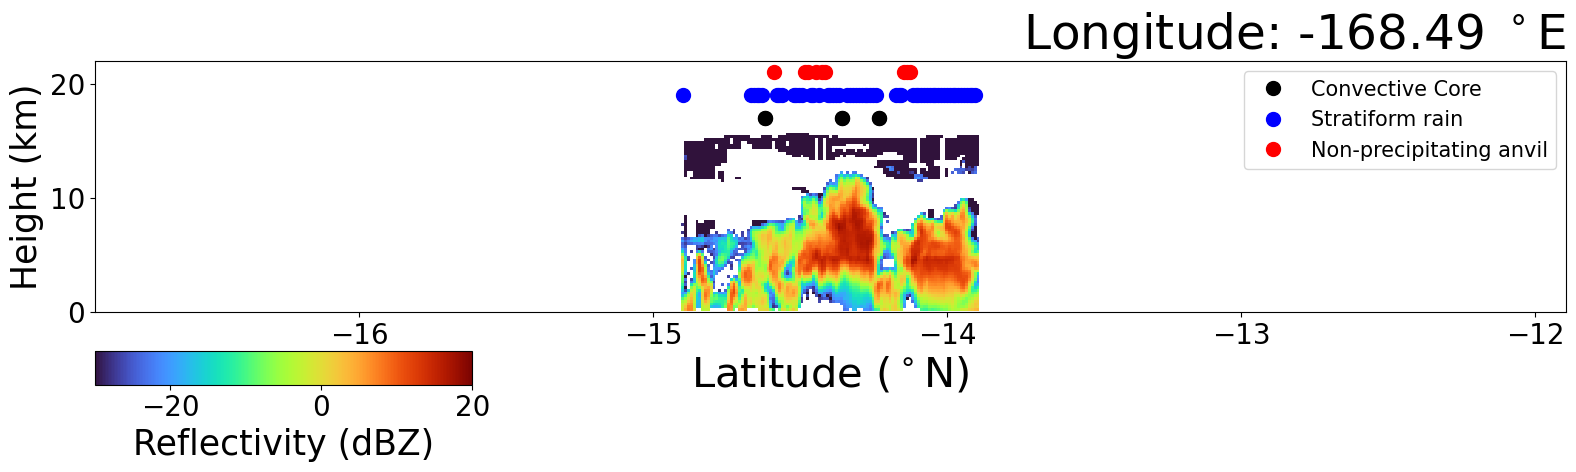

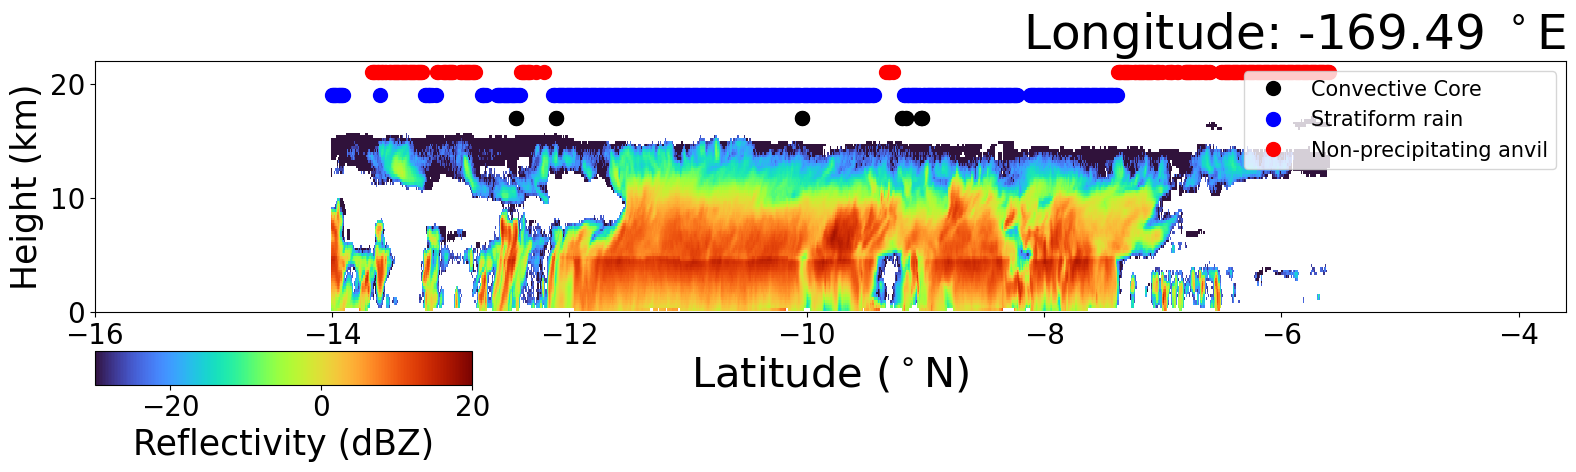

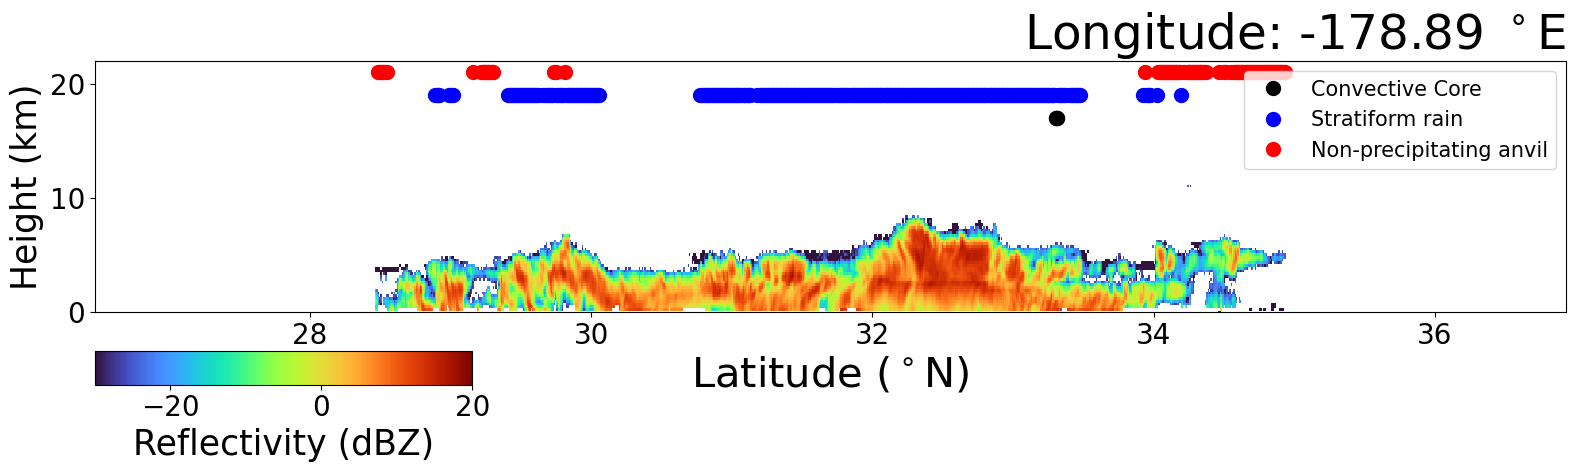

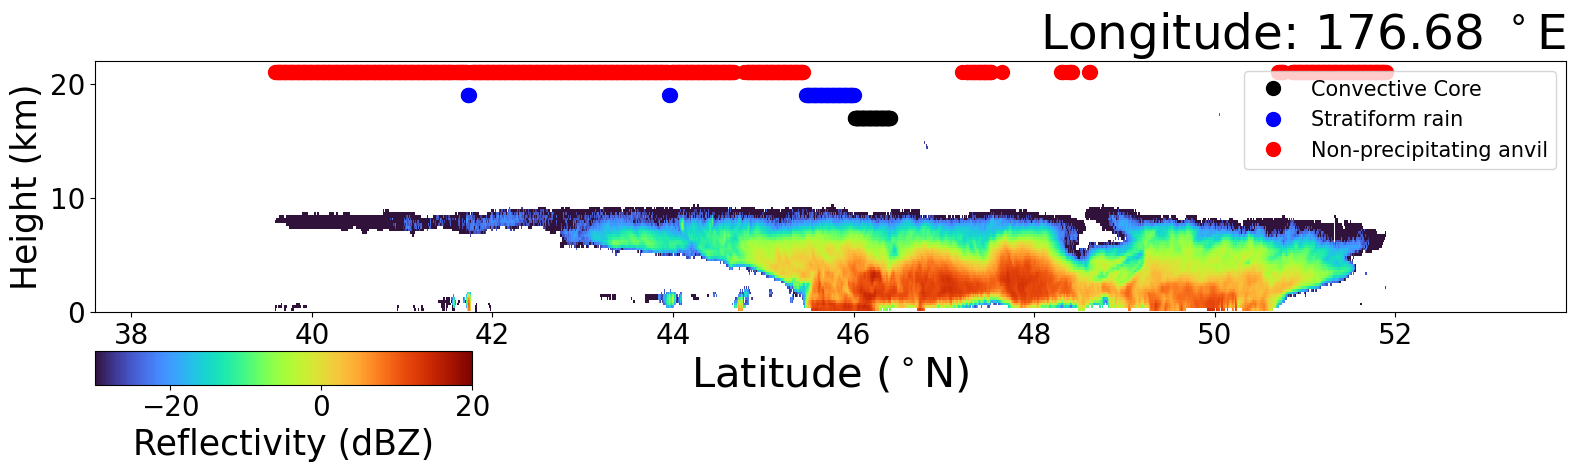

In [37]:
'''Reading in a file and plotting reflectivity profile'''

CO_file = glob.glob('/../doppler/data8/pilewskie/convective_object_database/Version_2/2014/' + \
    '*' + '40848' + '*.nc.gz') # Edit this text to add your own file path
                
infile = gzip.open(CO_file[0], 'rb')
tmp = tempfile.NamedTemporaryFile(dir='/dev/shm/')
shutil.copyfileobj(infile, tmp)
CO_data = nc4.Dataset(tmp.name, 'r', format = 'NETCDF4')
#os.unlink(tmp.name)
infile.close()
tmp.close()
        
## Reading in variables
            
# General information
lat = CO_data.variables['Latitudes of CO'][:]
lon = CO_data.variables['Longitudes of CO'][:] 
heights = CO_data.variables['Heights'][:]
            
# Core information
core_pix_i = CO_data.variables['Initial Core Index'][:]
core_pix_f = CO_data.variables['Final Core Index'][:]
            
# CO information
Z = CO_data.variables['Full Z Profile'][:]
cloud_region_flags = CO_data.variables['Cloud Region Flags'][:]
co_length = CO_data.variables['CO Length'][:]

for x in range(len(lat)):  
    
    if (co_length[x] is np.ma.masked) == True:
        continue
    else:
            
        ## Plotting a reflectivity profile for each CO

        fig = plt.figure(figsize = (20,20))
        grid = plt.GridSpec(85,20)
        ax = plt.subplot(grid[:14,:19])
        cbar_ax1 = plt.subplot(grid[16:18,:5]) # Reflectivity
    
        ax.set_facecolor('white')
        ax.set_xlim([lat[x,0][lat[x,0].mask == False][0]-2,lat[x,0][lat[x,0].mask == False][-1]+2])
        ax.tick_params(axis='x', labelsize= 20); ax.tick_params(axis='y', labelsize= 20)
        ax.set_xlabel('Latitude ($^\circ$N)', fontsize = 30)

        #================

        ## Vertical reflectivity profile

        # Plotting reflectivity profile
        pZ = ax.pcolormesh(lat[x,0][lat[x,0].mask == False], heights, \
        Z[x][:len(lat[x,0][lat[x,0].mask == False])].T, cmap = 'turbo', vmin = -30, vmax = 20)

        # Adding deep convective cores (this is equivalent to cloud_region_flags = 1)
        for k in range(len(core_pix_i[x])):
            if np.ma.is_masked(core_pix_i[x,k]) == True:
                continue                    
            else:
                m1, = ax.plot(lat[x,0][core_pix_i[x,k]:core_pix_f[x,k]+1], \
                np.ones(len(lat[x,0]))[core_pix_i[x,k]:core_pix_f[x,k]+1]*17, marker = 'o', \
                    color = 'black', markersize = 10, linestyle="None")
        
        # Adding stratiform rain flags
        strat_idx = [i for i,j in enumerate(cloud_region_flags[x]) if j == 2]
        m2, = ax.plot(lat[x,0][strat_idx], np.ones(len(lat[x,0]))[strat_idx]*19, marker = 'o', \
                        color = 'blue', markersize = 10, linestyle="None")
                    
        # Adding non-precipitating anvil flags
        anvil_idx = [i for i,j in enumerate(cloud_region_flags[x]) if j == 0]
        m3, = ax.plot(lat[x,0][anvil_idx], np.ones(len(lat[x,0]))[anvil_idx]*21, marker = 'o', \
                        color = 'red', markersize = 10, linestyle="None")

        ax.set_ylabel('Height (km)', fontsize = 25)
        ax.set_ylim([0,22])
        ax.set_title('Longitude: ' + "{:.2f}".format(np.ma.mean(lon[x,0])) + ' $^\circ$E', loc = 'right', fontsize = 35)
    
        # Create a legend
        ax.legend(handles=[m1, m2, m3], labels=['Convective Core', 'Stratiform rain', 'Non-precipitating anvil'], \
                     loc='upper right', fontsize=15)

        # Color bars
        cb = fig.colorbar(pZ, cax = cbar_ax1, orientation = 'horizontal')
        cb.set_label('Reflectivity (dBZ)', fontsize = 25); cb.ax.tick_params(labelsize=20)
                
        plt.show()
        
CO_data.close()